# 载入数据集
样本数据包含以下三份数据：
- 用户标签表：提供用户标签数据，共有43个标签，包括基本的人口统计学信息，经济情况；
- 交易行为表：包含用户过去60天的交易行为数据，共有8个标签；
- APP行为表：包含用户过去30天的APP行为数据，共有4个标签。

三份数据通过`id`字段作为标志进行链接。其中，用户标签表包含的字段最多，每一条记录为 `id`字段唯一的标识记录。在交易行为表和APP行为表中，同一个`id`可以存在多条记录，这两个表的与用户标签表的`id`相对应，且只有部分用户有相关数据。

`flag`字段为用户是否违约的标志，其中`flag`为`0`表示该用户被划分为违约型用户，`flag`为`1`表示该用户被划分为诚信型用户。

In [1]:
import os
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

train_path = 'C:/Users/zhang/mine/finTech/data/B/训练数据集'
test_path = 'C:/Users/zhang/mine/finTech/data/B/b'

train_tag_DF = pd.read_csv(train_path + '/训练数据集_tag.csv')
train_trd_DF = pd.read_csv(train_path + '/训练数据集_trd.csv')
train_beh_DF = pd.read_csv(train_path + '/训练数据集_beh.csv')

# 由于每个用户应该只有一条信息，交易信息以及app上的操作行为在同一时刻也应该只有一条操作，这里对三个数据进行去重操作
train_trd_DF.drop_duplicates(inplace = True)
train_trd_DF.drop_duplicates(inplace = True)
train_beh_DF.drop_duplicates(inplace = True)

# 用户标签表

In [2]:
print('类别分布情况: ')
print(train_tag_DF.flag.value_counts())

print('\n------------------------------------------------\n')
print('用户标签表变量信息: ')
print(train_tag_DF.info())

print('\n------------------------------------------------\n')
print('用户标签表前5行展示: ')
print(train_tag_DF.head().T)

print('\n------------------------------------------------\n')
print('用户标签表变量描述性统计: ')
print(train_tag_DF.describe())

类别分布情况: 
0    30970
1     8953
Name: flag, dtype: int64

------------------------------------------------

用户标签表变量信息: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39923 entries, 0 to 39922
Data columns (total 43 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   id                               39923 non-null  object
 1   flag                             39923 non-null  int64 
 2   gdr_cd                           39923 non-null  object
 3   age                              39923 non-null  int64 
 4   mrg_situ_cd                      39923 non-null  object
 5   edu_deg_cd                       27487 non-null  object
 6   acdm_deg_cd                      39922 non-null  object
 7   deg_cd                           18960 non-null  object
 8   job_year                         39923 non-null  object
 9   ic_ind                           39923 non-null  object
 10  fr_or_sh_ind                     39

数据中包含大量不是`int`或`float`类型的数据，使得许多列为`object`数据类型，观察发现出现了大量`\N`，`~`这种类型的标记，因此做了一些填充缺失数据的操作。

In [3]:
# 定义缺失值检测函数
def missing_value_detect(df):
    df1 = df.copy()
    df1 = df1.replace('\\N', np.nan)
    df1 = df1.replace('~', np.nan)
    mis_val = df1.isnull().sum()
    mis_val_percent = (df1.isnull().sum()/len(df)) * 100
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis = 1)
    mis_val_table = mis_val_table.rename(columns = {0:'缺失值', 1:'缺失率(%)'})
    mis_val_table = mis_val_table[mis_val_table.iloc[:, 1] != 0].sort_values('缺失率(%)', ascending = False)
    return mis_val_table

In [4]:
missing_values = missing_value_detect(train_tag_DF)
missing_values

,缺失值,缺失率(%)
deg_cd,38749,97.059339
atdd_type,23664,59.274103
edu_deg_cd,13280,33.264033
mrg_situ_cd,984,2.464745
acdm_deg_cd,737,1.846054
gdr_cd,736,1.843549
tot_ast_lvl_cd,500,1.252411
frs_agn_dt_cnt,500,1.252411
l12_mon_fnd_buy_whl_tms,500,1.252411
l12mon_buy_fin_mng_whl_tms,500,1.252411


从这里可以看到其中三个变量`edu_deg_cd`, `deg_cd`, `atdd_type`的缺失率比较高，而这三个变量分别对应教育程度、学位以及信用卡还款方式，其中前面两个变量与变量`deg_cd`（学位）类似，将这三个变量丢弃。

对于其他出现`\N`及`~`的情况，无法定义她们的具体意义，因此使用一个新的值进行替换。

In [5]:
train_tag_DF.drop(['edu_deg_cd', 'deg_cd', 'atdd_type'], axis = 1, inplace = True)

train_tag_DF = train_tag_DF.fillna('-2')
train_tag_DF = train_tag_DF.replace('\\N', '-2')
train_tag_DF = train_tag_DF.replace('~', '-2')

这里注意到，`~`只出现在字符串型变量`gdr_cd`, `mrg_situ_cd`, `acdm_deg_cd`。下面将所有数值型变量数据类型转为数值型。

In [6]:
strColName = ['gdr_cd', 'mrg_situ_cd', 'acdm_deg_cd']
colname = train_tag_DF.columns.values.tolist()
for col in colname[1:]:
    if (not np.issubdtype(train_tag_DF[col], np.int64)) and (col not in strColName):
        train_tag_DF[col] = train_tag_DF[col].astype(np.int64)

接着，对于其中的变量进行特征加工，比如进行次数统计等等操作。

In [7]:
train_tag_DF['I12_mon_whl_tms'] = train_tag_DF[['l12mon_buy_fin_mng_whl_tms',
                                                'l12_mon_fnd_buy_whl_tms',
                                                'l12_mon_insu_buy_whl_tms',
                                                'l12_mon_gld_buy_whl_tms']].apply(lambda x: x.fillna(0).astype(np.int).sum(), axis = 1).astype(np.int64)
# 理财产品、基金、保险、黄金购买次数总和

train_tag_DF['dnl_ind'] = train_tag_DF[['dnl_mbl_bnk_ind', 'dnl_bind_cmb_lif_ind']].apply(lambda x: x.sum(), axis = 1)
# 合并下载标志'dnl_mbl_bnk_ind', 'dnl_bind_cmb_lif_ind',

train_tag_DF['cur_debit_card'] = train_tag_DF[['cur_debit_cnt', 
                                               'cur_debit_min_opn_dt_cnt', 
                                               'cur_debit_crd_lvl']].apply(lambda x: x[0] * x[1] * x[2] / 100, axis = 1)

train_tag_DF['cur_credit_card'] = train_tag_DF[[ 'cur_credit_cnt', 
                                                'cur_credit_min_opn_dt_cnt', 
                                                'hld_crd_card_grd_cd',
                                                'crd_card_act_ind']].apply(lambda x: x[0] * x[1] * (x[2] + 1e-5) * (x[3] + 1e-5), axis = 1)

train_tag_DF['ic_fr_sh_ind'] = train_tag_DF[['ic_ind', 'fr_or_sh_ind']].apply(lambda x: 4 if ((x[0] == 1) & (x[1] == 1)) else (3 if (x[1] == 1) else (2 if (x[0] == 1) else (1 if ((x[0] == 0) & (x[1] == 0)) else 0))), axis = 1)
# 0: no, 1: ic, 2: fr or sh, 3: both

train_tag_DF['hav_car_hou_ind'] = train_tag_DF[['hav_car_grp_ind',
                                                'hav_hou_grp_ind']].apply(lambda x: 4 if ((x[0] == 1) & (x[1] == 1)) else (3 if (x[1] == 1) else (2 if (x[0] == 1) else (1 if ((x[0] == 0) & (x[1] == 0)) else 0))), axis = 1)
# 0: no, 1: Car, 2: House, 3: both

train_tag_DF['ovd_cnt'] = train_tag_DF[['ovd_30d_loan_tot_cnt',
                                        'his_lng_ovd_day']].apply(lambda x: x[0] * x[1], axis = 1)

train_tag_DF['rsk_combine'] = train_tag_DF[['vld_rsk_ases_ind',
                                         'fin_rsk_ases_grd_cd',
                                         'confirm_rsk_ases_lvl_typ_cd',
                                         'cust_inv_rsk_endu_lvl_cd',
                                        ]].apply(lambda x: -abs(x[0]*x[1]*x[2]*x[3]) if any(x<0) else x[0]*x[1]*x[2]*x[3], axis = 1)

train_tag_DF['ast_combine'] = train_tag_DF[['tot_ast_lvl_cd',
                                         'pot_ast_lvl_cd',
                                        ]].apply(lambda x: -abs(x[0]*x[1]) if any(x<0) else x[0]*x[1], axis = 1)

train_tag_DF['rsk_mean'] = train_tag_DF[['vld_rsk_ases_ind',
                                         'fin_rsk_ases_grd_cd',
                                         'confirm_rsk_ases_lvl_typ_cd',
                                         'cust_inv_rsk_endu_lvl_cd',
                                        ]].apply(lambda x: x.mean(), axis = 1)

train_tag_DF['ast_mean'] = train_tag_DF[['tot_ast_lvl_cd',
                                         'pot_ast_lvl_cd',
                                        ]].apply(lambda x: x.mean(), axis = 1)



# 交易行为表

In [8]:
print('类别分布情况: ')
print(train_trd_DF.flag.value_counts())

print('\n------------------------------------------------\n')
print('交易行为表变量信息: ')
print(train_trd_DF.info())

print('\n------------------------------------------------\n')
print('交易行为表前5行展示: ')
print(train_trd_DF.head().T)

print('\n------------------------------------------------\n')
print('交易行为表变量描述性统计: ')
print(train_trd_DF.describe())

类别分布情况: 
0    1149088
1     214798
Name: flag, dtype: int64

------------------------------------------------

交易行为表变量信息: 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1363886 entries, 0 to 1367210
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   id           1363886 non-null  object 
 1   flag         1363886 non-null  int64  
 2   Dat_Flg1_Cd  1363886 non-null  object 
 3   Dat_Flg3_Cd  1363886 non-null  object 
 4   Trx_Cod1_Cd  1363886 non-null  int64  
 5   Trx_Cod2_Cd  1363886 non-null  int64  
 6   trx_tm       1363886 non-null  object 
 7   cny_trx_amt  1363886 non-null  float64
dtypes: float64(1), int64(3), object(4)
memory usage: 93.7+ MB
None

------------------------------------------------

交易行为表前5行展示: 
                               0                    1                    2  \
id                       UFDC88A              UFDC88A              UFDC88A   
flag                           0     

交易行为表并没有出现缺失值情况，下面对交易行为数据分别从交易代码、支出与收入、交易方式、以及交易次数四个角度进行特征加工并于用户信息表进行合并。

## 交易代码

In [9]:
# 交易一级、二级最高频代码
trx_cod1_cd = train_trd_DF.groupby(['id', 'Trx_Cod1_Cd'])['trx_tm'].count()
trx_cod1_cd = trx_cod1_cd.reset_index()
trx_cod1_cd.rename(columns = {'trx_tm': 'trx_cod1_tms'}, inplace = True)
trx_cod1_cd.sort_values(['id', 'trx_cod1_tms'], inplace = True)

trx_cod1_cd.drop_duplicates('id', keep = 'last', inplace = True)
trx_cod1_cd.drop(['trx_cod1_tms'], axis = 1, inplace = True)
trx_cod1_cd.rename(columns = {'Trx_Cod1_Cd': 'most_Trx_Cod1_Cd'}, inplace = True)

trx_cod2_cd = train_trd_DF.groupby(['id', 'Trx_Cod2_Cd'])['trx_tm'].count()
trx_cod2_cd = trx_cod2_cd.reset_index()
trx_cod2_cd.rename(columns = {'trx_tm': 'trx_cod2_tms'}, inplace = True)
trx_cod2_cd.sort_values(['id', 'trx_cod2_tms'], inplace = True)

trx_cod2_cd.drop_duplicates('id', keep = 'last', inplace = True)
trx_cod2_cd.drop(['trx_cod2_tms'], axis = 1, inplace = True)
trx_cod2_cd.rename(columns = {'Trx_Cod2_Cd': 'most_Trx_Cod2_Cd'}, inplace = True)

# 与tag数据合并
train_DF = pd.merge(train_tag_DF, trx_cod1_cd, on = 'id', how = 'left')
train_DF = pd.merge(train_DF, trx_cod2_cd, on = 'id', how = 'left')

train_DF['most_Trx_Cod1_Cd'] = train_DF['most_Trx_Cod1_Cd'].fillna(0)
train_DF['most_Trx_Cod2_Cd'] = train_DF['most_Trx_Cod2_Cd'].fillna(0)

## 支出与收入

In [10]:
# 支出跟收入
# B: 支出, C: 收入
id_pay = train_trd_DF.groupby(['id', 'Dat_Flg1_Cd'])['cny_trx_amt'].sum().reset_index()

id_income = id_pay[id_pay['Dat_Flg1_Cd'] == 'C']
id_pay = id_pay[id_pay['Dat_Flg1_Cd'] == 'B']

id_income.reset_index(drop = True, inplace = True)
id_pay.reset_index(drop = True, inplace = True)

id_income.drop(['Dat_Flg1_Cd'], axis = 1, inplace = True)
id_pay.drop(['Dat_Flg1_Cd'], axis = 1, inplace = True)

id_income.rename(columns = {'cny_trx_amt': 'cny_trx_income'}, inplace = True)
id_pay.rename(columns = {'cny_trx_amt': 'cny_trx_pay'}, inplace = True)

id_income['cny_trx_income'] = id_income['cny_trx_income'].abs()
id_pay['cny_trx_pay'] = id_pay['cny_trx_pay'].abs()

# 跟tag合并
train_DF = pd.merge(train_DF, id_income, on = 'id', how = 'left')
train_DF = pd.merge(train_DF, id_pay, on = 'id', how = 'left')

train_DF['cny_trx_income'] = train_DF['cny_trx_income'].fillna(0)
train_DF['cny_trx_pay'] = train_DF['cny_trx_pay'].fillna(0)
# 净收入\支出
train_DF['actual_income'] = train_DF[['cny_trx_income', 'cny_trx_pay']].apply(lambda x: x[0] - x[1], axis = 1)

## 交易方式

In [11]:
# 交易方式
trx_way = train_trd_DF.groupby(['id', 'Dat_Flg3_Cd'])['trx_tm'].count()
trx_way = trx_way.reset_index()
trx_way.rename(columns = {'trx_tm': 'trx_way_tms'}, inplace = True)
trx_way.sort_values(['id', 'trx_way_tms'], inplace = True)

trx_way.drop_duplicates('id', keep = 'last', inplace = True)
trx_way.drop(['trx_way_tms'], axis = 1, inplace = True)
trx_way.rename(columns = {'Dat_Flg3_Cd': 'most_trx_way'}, inplace = True)
train_DF = pd.merge(train_DF, trx_way, on = 'id', how = 'left')
train_DF['most_trx_way'] = train_DF['most_trx_way'].fillna('Undo')

## 交易次数

In [12]:
# 交易次数
trx_tms = train_trd_DF.groupby(['id'])['trx_tm'].count()
trx_tms = trx_tms.reset_index()
trx_tms.rename(columns = {'trx_tm': 'trx_tms'}, inplace = True)
train_DF = pd.merge(train_DF, trx_tms, on = 'id', how = 'left')
train_DF['trx_tms'] = train_DF['trx_tms'].fillna(0)

trx_Dat_Flg1_Cd_cnt = pd.crosstab(train_trd_DF['id'],train_trd_DF['Dat_Flg1_Cd'])
trx_Dat_Flg1_Cd_cnt = trx_Dat_Flg1_Cd_cnt.reset_index()
temp_columns = trx_Dat_Flg1_Cd_cnt.columns.tolist()
for col in temp_columns[1:]:
    trx_Dat_Flg1_Cd_cnt.rename(columns = {col: 'Dat_Flg1_Cd_' + col}, inplace = True)
train_DF = pd.merge(train_DF, trx_Dat_Flg1_Cd_cnt, on = 'id', how = 'left')

temp_columns = trx_Dat_Flg1_Cd_cnt.columns.tolist()
for col in temp_columns[1:]:
    train_DF[col] = train_DF[col].fillna(0)

trx_Dat_Flg3_Cd_cnt = pd.crosstab(train_trd_DF['id'],train_trd_DF['Dat_Flg3_Cd'])
trx_Dat_Flg3_Cd_cnt = trx_Dat_Flg3_Cd_cnt.reset_index()
temp_columns = trx_Dat_Flg3_Cd_cnt.columns.tolist()
for col in temp_columns[1:]:
    trx_Dat_Flg3_Cd_cnt.rename(columns = {col: 'Dat_Flg3_Cd_' + col}, inplace = True)
train_DF = pd.merge(train_DF, trx_Dat_Flg3_Cd_cnt, on = 'id', how = 'left')

temp_columns = trx_Dat_Flg3_Cd_cnt.columns.tolist()
for col in temp_columns[1:]:
    train_DF[col] = train_DF[col].fillna(0)

# APP行为表

In [13]:
print('类别分布情况: ')
print(train_beh_DF.flag.value_counts())

print('\n------------------------------------------------\n')
print('APP行为表变量信息: ')
print(train_beh_DF.info())

print('\n------------------------------------------------\n')
print('APP行为表前5行展示: ')
print(train_beh_DF.head().T)

print('\n------------------------------------------------\n')
print('APP行为表变量描述性统计: ')
print(train_beh_DF.describe())

类别分布情况: 
0    734406
1    130469
Name: flag, dtype: int64

------------------------------------------------

APP行为表变量信息: 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 864875 entries, 0 to 934281
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          864875 non-null  object 
 1   flag        864875 non-null  int64  
 2   page_no     864875 non-null  object 
 3   Unnamed: 3  864875 non-null  object 
 4   page_tm     0 non-null       float64
dtypes: float64(1), int64(1), object(3)
memory usage: 39.6+ MB
None

------------------------------------------------

APP行为表前5行展示: 
                              0                    1                    2  \
id                      U64F0C9              U64F0C9              U64F0C9   
flag                          0                    0                    0   
page_no                     SZA                  CQE                  AAO   
Unnamed: 3  2019-06-30 12:44:27  

这里发现访问时间`page_tm`这一列被错误放置到了一个新的列名`Unnamed: 3`，其余变量均无缺失情况。

In [14]:
train_beh_DF.drop(['page_tm'], axis = 1, inplace = True)
train_beh_DF.rename(columns = {'Unnamed: 3': 'page_tm'}, inplace = True)

In [15]:
print('类别分布情况: ')
print(train_beh_DF.flag.value_counts())

print('\n------------------------------------------------\n')
print('APP行为表变量信息: ')
print(train_beh_DF.info())

print('\n------------------------------------------------\n')
print('APP行为表前5行展示: ')
print(train_beh_DF.head().T)

print('\n------------------------------------------------\n')
print('APP行为表变量描述性统计: ')
print(train_beh_DF.describe())

类别分布情况: 
0    734406
1    130469
Name: flag, dtype: int64

------------------------------------------------

APP行为表变量信息: 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 864875 entries, 0 to 934281
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   id       864875 non-null  object
 1   flag     864875 non-null  int64 
 2   page_no  864875 non-null  object
 3   page_tm  864875 non-null  object
dtypes: int64(1), object(3)
memory usage: 33.0+ MB
None

------------------------------------------------

APP行为表前5行展示: 
                           0                    1                    2  \
id                   U64F0C9              U64F0C9              U64F0C9   
flag                       0                    0                    0   
page_no                  SZA                  CQE                  AAO   
page_tm  2019-06-30 12:44:27  2019-06-25 16:15:11  2019-06-30 12:44:17   

                           3                    

下面分别从浏览页面、每个用户浏览最多次的页面及种类数、每个用户浏览页面的次数四方面进行特征加工并进行合并。

In [16]:
# 浏览页面
beh_page_no_cnt = pd.crosstab(train_trd_DF['id'],train_beh_DF['page_no'])
beh_page_no_cnt = beh_page_no_cnt.reset_index()
page_no_columns = beh_page_no_cnt.columns.tolist()
for col in page_no_columns[1:]:
    beh_page_no_cnt.rename(columns = {col: 'beh_page_no_' + col}, inplace = True)
train_DF = pd.merge(train_DF, beh_page_no_cnt, on = 'id', how = 'left')
page_no_columns = beh_page_no_cnt.columns.tolist()
for col in page_no_columns[1:]:
    train_DF[col] = train_DF[col].fillna(0)
    
## 每个用户浏览最多次的页面
id_beh = train_beh_DF.groupby(['id', 'page_no'])['page_tm'].count()
id_beh = id_beh.reset_index()
id_beh.rename(columns = {'page_tm': 'page_tms'}, inplace = True)
id_beh.sort_values(['id', 'page_tms'], inplace = True)

# 种类数
id_beh_class_count = id_beh.groupby(['id']).count()
id_beh_class_count = id_beh_class_count.reset_index()
id_beh_class_count.drop(['page_tms'], axis = 1, inplace = True)
id_beh_class_count.rename(columns = {'page_no': 'page_type_count'}, inplace = True)

id_beh.drop_duplicates('id', keep = 'last', inplace = True)
id_beh.drop(['page_tms'], axis = 1, inplace = True)
id_beh.rename(columns = {'page_no': 'most_tms_page_no'}, inplace = True)

# 统计每个用户浏览页面的次数
beh_count = train_beh_DF.groupby(['id'])['page_tm'].count()
beh_count = beh_count.reset_index()
beh_count.rename(columns = {'page_tm': 'total_page_no_tms'}, inplace = True)

train_DF = pd.merge(train_DF, id_beh_class_count, on = 'id', how = 'left')
train_DF = pd.merge(train_DF, id_beh, on = 'id', how = 'left')
train_DF = pd.merge(train_DF, beh_count, on = 'id', how = 'left')

#train_DF['total_page_no_tms'] = train_DF['total_page_no_tms'].fillna(0)
#train_DF['total_page_no_tms'] = train_DF['total_page_no_tms'].astype(np.int64)
train_DF[['total_page_no_tms', 'page_type_count']] = train_DF[['total_page_no_tms', 'page_type_count']].fillna(0)
train_DF[['total_page_no_tms', 'page_type_count']] = train_DF[['total_page_no_tms', 'page_type_count']].astype(np.int64)

train_DF['most_tms_page_no'] = train_DF['most_tms_page_no'].fillna('Undo')

# 最终合并的数据

In [17]:
print('类别分布情况: ')
print(train_DF.flag.value_counts())

print('\n------------------------------------------------\n')
print('变量信息: ')
print(train_DF.info())

print('\n------------------------------------------------\n')
print('前5行展示: ')
print(train_DF.head().T)

print('\n------------------------------------------------\n')
print('变量描述性统计: ')
print(train_DF.describe())

类别分布情况: 
0    30970
1     8953
Name: flag, dtype: int64

------------------------------------------------

变量信息: 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 39923 entries, 0 to 39922
Data columns (total 95 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               39923 non-null  object 
 1   flag                             39923 non-null  int64  
 2   gdr_cd                           39923 non-null  object 
 3   age                              39923 non-null  int64  
 4   mrg_situ_cd                      39923 non-null  object 
 5   acdm_deg_cd                      39923 non-null  object 
 6   job_year                         39923 non-null  int64  
 7   ic_ind                           39923 non-null  int64  
 8   fr_or_sh_ind                     39923 non-null  int64  
 9   dnl_mbl_bnk_ind                  39923 non-null  int64  
 10  dnl_bind_cmb_lif_ind        

# 模型训练准备
载入相关库以及评价函数

In [18]:
import xgboost as xgb
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier ,RandomForestRegressor
from sklearn.model_selection import KFold,train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,accuracy_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, precision_score, recall_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn import model_selection
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB  
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import StratifiedKFold  
from sklearn.model_selection import KFold  
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier

random_seed = 2020
np.random.seed(2)

################
## 评价函数 
def perfomance_clf(model, X, y, name=None):
    y_predict = model.predict(X)
    y_predict_prob = model.predict_proba(X)[:, 1]
    if name:
        print(name,':')
    print(f'accuracy score is: {accuracy_score(y, y_predict)}')
    print(f'precision score is: {precision_score(y, y_predict)}')
    print(f'recall score is: {recall_score(y, y_predict)}')
    print(f'auc: {roc_auc_score(y, y_predict_prob)}')
    print('- - - - - - ')
    
def plot_roc(y_test, prob, model_name = ''):
    fpr, tpr, thresholds = roc_curve(y_test, prob)
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr)#, marker='.')
    plt.title(model_name + "ROC curve")
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    # show the plot
    plt.show()    

C:\ProgramData\Anaconda3\lib\site-packages\dask\dataframe\utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 未进行特征处理的违约预测分析
首先提取字符串变量，为后续特征处理做准备

In [19]:
train_DF_weneed = train_DF.drop(['id'], axis = 1)
strCol2 = []
for col in train_DF_weneed.columns.values.tolist():
    if (not np.issubdtype(train_DF_weneed[col], np.int64)) and (not np.issubdtype(train_DF_weneed[col], np.float64)):
        strCol2.append(col)
        
strCol2

['gdr_cd', 'mrg_situ_cd', 'acdm_deg_cd', 'most_trx_way', 'most_tms_page_no']

In [20]:
train_DF_weneed[['gdr_cd', 'mrg_situ_cd', 'acdm_deg_cd', 'most_trx_way', 'most_tms_page_no']].head()

,gdr_cd,mrg_situ_cd,acdm_deg_cd,most_trx_way,most_tms_page_no
0,M,B,Z,C,Undo
1,M,A,G,Undo,Undo
2,M,B,C,A,CQA
3,F,B,Z,Undo,Undo
4,F,B,Z,A,CQA


In [21]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
encoderLabel = LabelEncoder()

for sC in strCol2:
    print(sC)
    sC_class = train_DF_weneed[sC].unique().tolist()
    sC_class_label = encoderLabel.fit_transform(sC_class)
    train_DF_weneed[sC] = encoderLabel.transform(train_DF_weneed[sC])
    
train_DF_weneed.head()

gdr_cd
mrg_situ_cd
acdm_deg_cd
most_trx_way
most_tms_page_no


,flag,gdr_cd,age,mrg_situ_cd,acdm_deg_cd,job_year,ic_ind,fr_or_sh_ind,dnl_mbl_bnk_ind,dnl_bind_cmb_lif_ind,hav_car_grp_ind,hav_hou_grp_ind,l6mon_agn_ind,frs_agn_dt_cnt,vld_rsk_ases_ind,fin_rsk_ases_grd_cd,confirm_rsk_ases_lvl_typ_cd,cust_inv_rsk_endu_lvl_cd,l6mon_daim_aum_cd,tot_ast_lvl_cd,pot_ast_lvl_cd,bk1_cur_year_mon_avg_agn_amt_cd,l12mon_buy_fin_mng_whl_tms,l12_mon_fnd_buy_whl_tms,l12_mon_insu_buy_whl_tms,l12_mon_gld_buy_whl_tms,loan_act_ind,pl_crd_lmt_cd,ovd_30d_loan_tot_cnt,his_lng_ovd_day,hld_crd_card_grd_cd,crd_card_act_ind,l1y_crd_card_csm_amt_dlm_cd,perm_crd_lmt_cd,cur_debit_cnt,cur_credit_cnt,cur_debit_min_opn_dt_cnt,cur_credit_min_opn_dt_cnt,cur_debit_crd_lvl,I12_mon_whl_tms,dnl_ind,cur_debit_card,cur_credit_card,ic_fr_sh_ind,hav_car_hou_ind,ovd_cnt,rsk_combine,ast_combine,rsk_mean,ast_mean,most_Trx_Cod1_Cd,most_Trx_Cod2_Cd,cny_trx_income,cny_trx_pay,actual_income,most_trx_way,trx_tms,Dat_Flg1_Cd_B,Dat_Flg1_Cd_C,Dat_Flg3_Cd_A,Dat_Flg3_Cd_B,Dat_Flg3_Cd_C,beh_page_no_AAO,beh_page_no_BWA,beh_page_no_BWE,beh_page_no_CQA,beh_page_no_CQB,beh_page_no_CQC,beh_page_no_CQD,beh_page_no_CQE,beh_page_no_CTR,beh_page_no_EGA,beh_page_no_EGB,beh_page_no_FDA,beh_page_no_FLS,beh_page_no_FTR,beh_page_no_GBA,beh_page_no_JF2,beh_page_no_JJD,beh_page_no_JJK,beh_page_no_LC0,beh_page_no_LCT,beh_page_no_MSG,beh_page_no_MTA,beh_page_no_SYK,beh_page_no_SZA,beh_page_no_SZD,beh_page_no_TRN,beh_page_no_XAG,beh_page_no_XAI,beh_page_no_ZY1,page_type_count,most_tms_page_no,total_page_no_tms
0,0,2,41,2,7,3,0,0,0,1,0,0,0,-1,0,-1,4,1,0,-1,6,0,0,0,0,0,0,0,0,0,-1,0,0,3,1,0,3492,-1,10,0,1,349.2,-0.0,1,1,0,0,-6,1.00,2.5,2.0,208.0,17400.00,15000.00,2400.00,2,3.0,1.0,2.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0,22,0
1,0,2,35,1,6,4,0,0,0,0,0,0,0,-1,0,-1,-1,1,0,-1,-1,0,0,0,0,0,0,0,0,0,-1,0,0,1,1,0,4575,-1,10,0,0,457.5,-0.0,1,1,0,0,-1,-0.25,-1.0,0.0,0.0,0.00,0.00,0.00,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,22,0
2,0,2,53,2,3,9,0,0,1,1,0,0,1,935,1,3,3,6,7,-1,2,8,6,0,0,0,0,0,0,0,-1,0,0,7,2,0,4894,-1,40,6,2,3915.2,-0.0,1,1,0,54,-2,3.25,0.5,2.0,208.0,105718.04,131158.00,-25439.96,0,17.0,6.0,11.0,17.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,0.0,6,2,31
3,0,1,41,2,7,0,0,0,0,0,0,0,0,-1,0,-1,-1,1,0,-1,6,0,0,0,0,0,0,0,0,0,-1,0,0,1,1,0,4938,-1,10,0,0,493.8,-0.0,1,1,0,0,-6,-0.25,2.5,0.0,0.0,0.00,0.00,0.00,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,22,0
4,0,1,42,2,7,3,1,1,1,0,0,1,0,-1,0,-1,-1,1,5,-1,3,0,0,0,0,0,1,6,0,4,-1,0,0,2,7,0,2378,-1,20,0,1,3329.2,-0.0,4,3,0,0,-3,-0.25,1.0,2.0,308.0,79505.55,70416.04,9089.51,0,18.0,5.0,13.0,18.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,7,2,20


划分训练集与测试集

In [22]:
df_x = train_DF_weneed.drop(['flag'], axis = 1)
df_y = train_DF_weneed['flag']
trainx, testx, trainy, testy = train_test_split(df_x, df_y, test_size = 0.2, random_state = random_seed)

## Logistic回归分析

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


roc  0.5235906701968386
accuracy score is: 0.7814652473387602
precision score is: 0.125
recall score is: 0.0005750431282346176
auc: 0.5235906701968386
- - - - - - 


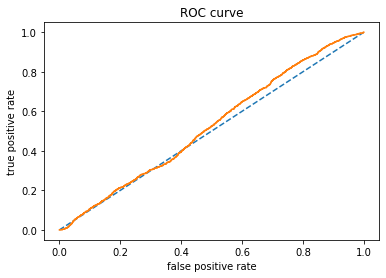

In [23]:
logit_clf = LogisticRegression(solver = 'lbfgs')  

logit_clf.fit(trainx, trainy)
y_score_logit = logit_clf.predict_proba(testx)[:, 1]
roc_logit = roc_auc_score(testy, y_score_logit)

print('roc ',roc_logit)
perfomance_clf(logit_clf, testx, testy)
plot_roc(testy, y_score_logit)

## RandomForest

roc  0.7426124082264863
accuracy score is: 0.7967438948027552
precision score is: 0.6986301369863014
recall score is: 0.11730879815986199
auc: 0.7426124082264863
- - - - - - 


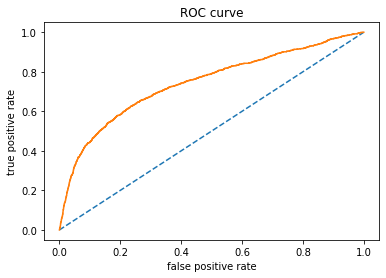

In [24]:
rf_cfl = RandomForestClassifier(n_estimators = 200,
                               min_samples_split = 5,
                               min_samples_leaf = 4,
                               max_features = 3)

rf_cfl.fit(trainx, trainy)
y_score_rf = rf_cfl.predict_proba(testx)[:,1]
roc_rf = roc_auc_score(testy, y_score_rf)

print('roc ',roc_rf)
perfomance_clf(rf_cfl, testx, testy)
plot_roc(testy, y_score_rf)

## XGBoost

roc  0.7511082423400776
accuracy score is: 0.8142767689417658
precision score is: 0.6628498727735369
recall score is: 0.2995974698102358
auc: 0.7511082423400776
- - - - - - 


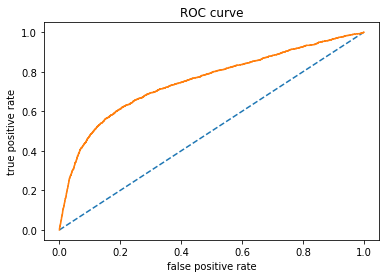

In [25]:
xgb_cfl = xgb.XGBClassifier(n_jobs = -1,
                            n_estimators = 100,
                            max_depth = 3)

xgb_cfl.fit(trainx, trainy)
y_score_xgb = xgb_cfl.predict_proba(testx)[:,1]
roc_xgb = roc_auc_score(testy, y_score_xgb)

print('roc ',roc_xgb)
perfomance_clf(xgb_cfl, testx, testy)
plot_roc(testy, y_score_xgb)

## AdaBoost

roc  0.7439273383383997
accuracy score is: 0.811020663744521
precision score is: 0.6785714285714286
recall score is: 0.25129384703852786
auc: 0.7439273383383997
- - - - - - 


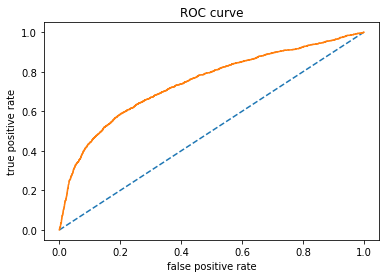

In [26]:
ada_cfl = AdaBoostClassifier(n_estimators = 200)

ada_cfl.fit(trainx, trainy)
y_score_ada = ada_cfl.predict_proba(testx)[:,1]
roc_ada = roc_auc_score(testy, y_score_ada)

print('roc ',roc_ada)
perfomance_clf(ada_cfl, testx, testy)
plot_roc(testy, y_score_ada)

## GradientBoosting

roc  0.7538549801257508
accuracy score is: 0.815278647463995
precision score is: 0.6590361445783133
recall score is: 0.3145485911443358
auc: 0.7538549801257508
- - - - - - 


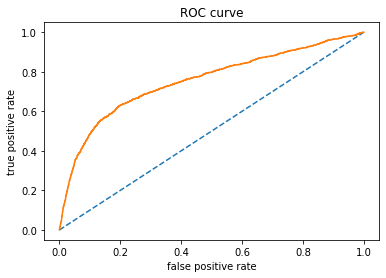

In [27]:
gdbt_cfl = GradientBoostingClassifier(n_estimators=110,
                                   min_samples_split=12,
                                   min_samples_leaf=6,
                                   max_depth=6)

gdbt_cfl.fit(trainx, trainy)
y_score_gdbt = gdbt_cfl.predict_proba(testx)[:,1]
roc_gdbt = roc_auc_score(testy, y_score_gdbt)

print('roc ',roc_gdbt)
perfomance_clf(gdbt_cfl, testx, testy)
plot_roc(testy, y_score_gdbt)

# 特征处理
## 去除共线性变量

In [28]:
train_x = train_DF_weneed.drop(['flag'], axis = 1)
train_y = train_DF_weneed.flag
colname = train_x.columns.values.tolist()

# Threshold for removing correlated variables
threshold = 0.97
# Absolute value correlation matrix
corr_matrix = train_x.corr().abs()
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print('There are %d columns to remove: ' % (len(to_drop)))
for i in to_drop:
    print(i)

train_x = train_x.drop(columns = to_drop)

There are 1 columns to remove: 
cny_trx_pay


## 特征选择
这里采用XGBoost进行特征选择

In [29]:
train_x = train_DF_weneed.drop(['flag'], axis = 1)
train_y = train_DF_weneed.flag
colname = train_x.columns.values.tolist()

import xgboost as xgb
xgb_feature_cfl = xgb.XGBClassifier(n_jobs = -1, n_estimators = 50,
                                    class_weight = 'balanced', max_depth = 3)

xgb_feature_cfl.fit(train_x, train_y)
xgb_feature = pd.DataFrame({'feature': colname, 'importance': xgb_feature_cfl.feature_importances_}).sort_values('importance', ascending = False).reset_index(drop = True)
xgb_feature

,feature,importance
0,l1y_crd_card_csm_amt_dlm_cd,0.083668
1,cny_trx_income,0.071844
2,gdr_cd,0.063658
3,dnl_ind,0.060146
4,most_Trx_Cod2_Cd,0.053197
...,...,...
88,beh_page_no_BWA,0.000000
89,bk1_cur_year_mon_avg_agn_amt_cd,0.000000
90,l12_mon_insu_buy_whl_tms,0.000000
91,l12_mon_gld_buy_whl_tms,0.000000


In [30]:
zero_features = list(xgb_feature[xgb_feature['importance']== 0.0]['feature'])
print('有%d个特征的特征重要性为0.0: '%len(zero_features))
print(zero_features)

有32个特征的特征重要性为0.0: 
['rsk_combine', 'beh_page_no_SYK', 'beh_page_no_JJK', 'beh_page_no_LC0', 'beh_page_no_LCT', 'hav_hou_grp_ind', 'beh_page_no_MTA', 'beh_page_no_SZD', 'beh_page_no_SZA', 'ic_ind', 'beh_page_no_TRN', 'l6mon_agn_ind', 'beh_page_no_XAI', 'beh_page_no_ZY1', 'beh_page_no_JJD', 'fin_rsk_ases_grd_cd', 'vld_rsk_ases_ind', 'crd_card_act_ind', 'beh_page_no_FLS', 'beh_page_no_FDA', 'ic_fr_sh_ind', 'beh_page_no_EGA', 'beh_page_no_CTR', 'beh_page_no_CQE', 'confirm_rsk_ases_lvl_typ_cd', 'beh_page_no_CQC', 'beh_page_no_BWE', 'beh_page_no_BWA', 'bk1_cur_year_mon_avg_agn_amt_cd', 'l12_mon_insu_buy_whl_tms', 'l12_mon_gld_buy_whl_tms', 'beh_page_no_EGB']


In [31]:
try:
    zero_features.remove('ovd_30d_loan_tot_cnt')
except:
    pass

# 经过特征处理的违约预测模型训练

In [32]:
train_DF_weneed = train_DF.drop(['id'] + zero_features, axis = 1)
strCol2 = []
for col in train_DF_weneed.columns.values.tolist():
    if (not np.issubdtype(train_DF_weneed[col], np.int64)) and (not np.issubdtype(train_DF_weneed[col], np.float64)):
        strCol2.append(col)
        
strCol2

['gdr_cd', 'mrg_situ_cd', 'acdm_deg_cd', 'most_trx_way', 'most_tms_page_no']

In [33]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
encoderLabel = LabelEncoder()

for sC in strCol2:
    print(sC)
    sC_class = train_DF_weneed[sC].unique().tolist()
    sC_class_label = encoderLabel.fit_transform(sC_class)
    train_DF_weneed[sC] = encoderLabel.transform(train_DF_weneed[sC])
    
train_DF_weneed.head()

gdr_cd
mrg_situ_cd
acdm_deg_cd
most_trx_way
most_tms_page_no


,flag,gdr_cd,age,mrg_situ_cd,acdm_deg_cd,job_year,fr_or_sh_ind,dnl_mbl_bnk_ind,dnl_bind_cmb_lif_ind,hav_car_grp_ind,frs_agn_dt_cnt,cust_inv_rsk_endu_lvl_cd,l6mon_daim_aum_cd,tot_ast_lvl_cd,pot_ast_lvl_cd,l12mon_buy_fin_mng_whl_tms,l12_mon_fnd_buy_whl_tms,loan_act_ind,pl_crd_lmt_cd,ovd_30d_loan_tot_cnt,his_lng_ovd_day,hld_crd_card_grd_cd,l1y_crd_card_csm_amt_dlm_cd,perm_crd_lmt_cd,cur_debit_cnt,cur_credit_cnt,cur_debit_min_opn_dt_cnt,cur_credit_min_opn_dt_cnt,cur_debit_crd_lvl,I12_mon_whl_tms,dnl_ind,cur_debit_card,cur_credit_card,hav_car_hou_ind,ovd_cnt,ast_combine,rsk_mean,ast_mean,most_Trx_Cod1_Cd,most_Trx_Cod2_Cd,cny_trx_income,cny_trx_pay,actual_income,most_trx_way,trx_tms,Dat_Flg1_Cd_B,Dat_Flg1_Cd_C,Dat_Flg3_Cd_A,Dat_Flg3_Cd_B,Dat_Flg3_Cd_C,beh_page_no_AAO,beh_page_no_CQA,beh_page_no_CQB,beh_page_no_CQD,beh_page_no_FTR,beh_page_no_GBA,beh_page_no_JF2,beh_page_no_MSG,beh_page_no_XAG,page_type_count,most_tms_page_no,total_page_no_tms
0,0,2,41,2,7,3,0,0,1,0,-1,1,0,-1,6,0,0,0,0,0,0,-1,0,3,1,0,3492,-1,10,0,1,349.2,-0.0,1,0,-6,1.00,2.5,2.0,208.0,17400.00,15000.00,2400.00,2,3.0,1.0,2.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,22,0
1,0,2,35,1,6,4,0,0,0,0,-1,1,0,-1,-1,0,0,0,0,0,0,-1,0,1,1,0,4575,-1,10,0,0,457.5,-0.0,1,0,-1,-0.25,-1.0,0.0,0.0,0.00,0.00,0.00,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,22,0
2,0,2,53,2,3,9,0,1,1,0,935,6,7,-1,2,6,0,0,0,0,0,-1,0,7,2,0,4894,-1,40,6,2,3915.2,-0.0,1,0,-2,3.25,0.5,2.0,208.0,105718.04,131158.00,-25439.96,0,17.0,6.0,11.0,17.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,6,2,31
3,0,1,41,2,7,0,0,0,0,0,-1,1,0,-1,6,0,0,0,0,0,0,-1,0,1,1,0,4938,-1,10,0,0,493.8,-0.0,1,0,-6,-0.25,2.5,0.0,0.0,0.00,0.00,0.00,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,22,0
4,0,1,42,2,7,3,1,1,0,0,-1,1,5,-1,3,0,0,1,6,0,4,-1,0,2,7,0,2378,-1,20,0,1,3329.2,-0.0,3,0,-3,-0.25,1.0,2.0,308.0,79505.55,70416.04,9089.51,0,18.0,5.0,13.0,18.0,0.0,0.0,0.0,6.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,7,2,20


划分训练集与测试集

In [34]:
df_x = train_DF_weneed.drop(['flag'], axis = 1)
df_y = train_DF_weneed['flag']
trainx, testx, trainy, testy = train_test_split(df_x, df_y, test_size = 0.2, random_state = random_seed)

## Logistic回归

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


roc  0.5239551587886864
accuracy score is: 0.7814652473387602
precision score is: 0.125
recall score is: 0.0005750431282346176
auc: 0.5239551587886864
- - - - - - 


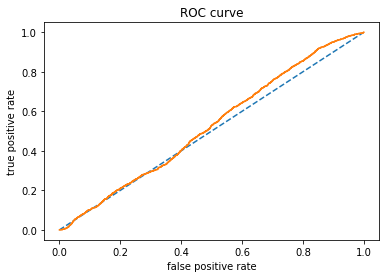

In [35]:
logit_clf = LogisticRegression(solver = 'lbfgs')  

logit_clf.fit(trainx, trainy)
y_score_logit = logit_clf.predict_proba(testx)[:, 1]
roc_logit = roc_auc_score(testy, y_score_logit)

print('roc ',roc_logit)
perfomance_clf(logit_clf, testx, testy)
plot_roc(testy, y_score_logit)

## RandomForest

roc  0.7473516805787331
accuracy score is: 0.800375704445836
precision score is: 0.6614699331848553
recall score is: 0.17078780908568142
auc: 0.7473516805787331
- - - - - - 


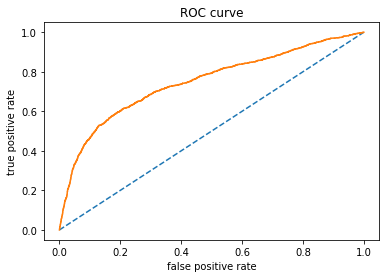

In [36]:
rf_cfl = RandomForestClassifier(n_estimators = 200,
                               min_samples_split = 5,
                               min_samples_leaf = 4,
                               max_features = 3)

rf_cfl.fit(trainx, trainy)
y_score_rf = rf_cfl.predict_proba(testx)[:,1]
roc_rf = roc_auc_score(testy, y_score_rf)

print('roc ',roc_rf)
perfomance_clf(rf_cfl, testx, testy)
plot_roc(testy, y_score_rf)

## XGBoost

roc  0.7550244002049754
accuracy score is: 0.8145272385723231
precision score is: 0.6637055837563451
recall score is: 0.300747556066705
auc: 0.7550244002049754
- - - - - - 


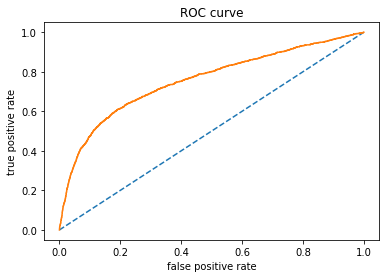

In [37]:
xgb_cfl = xgb.XGBClassifier(n_jobs = -1,
                            n_estimators = 100,
                            max_depth = 3)

xgb_cfl.fit(trainx, trainy)
y_score_xgb = xgb_cfl.predict_proba(testx)[:,1]
roc_xgb = roc_auc_score(testy, y_score_xgb)

print('roc ',roc_xgb)
perfomance_clf(xgb_cfl, testx, testy)
plot_roc(testy, y_score_xgb)

## AdaBoost

roc  0.7451903433263418
accuracy score is: 0.8102692548528491
precision score is: 0.6772151898734177
recall score is: 0.24611845888441633
auc: 0.7451903433263418
- - - - - - 


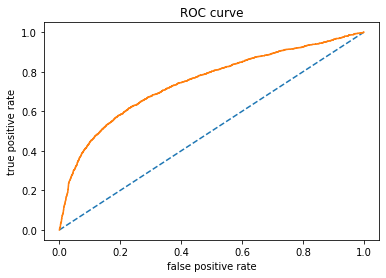

In [38]:
ada_cfl = AdaBoostClassifier(n_estimators = 200)

ada_cfl.fit(trainx, trainy)
y_score_ada = ada_cfl.predict_proba(testx)[:,1]
roc_ada = roc_auc_score(testy, y_score_ada)

print('roc ',roc_ada)
perfomance_clf(ada_cfl, testx, testy)
plot_roc(testy, y_score_ada)

## GradienBoosting

roc  0.759536500139848
accuracy score is: 0.817783343769568
precision score is: 0.668646080760095
recall score is: 0.3237492811960897
auc: 0.759536500139848
- - - - - - 


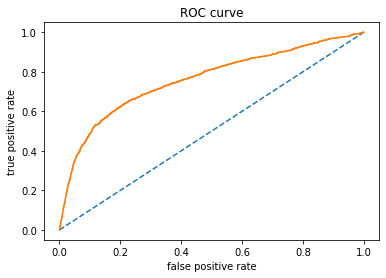

In [39]:
gdbt_cfl = GradientBoostingClassifier(n_estimators=110,
                                   min_samples_split=12,
                                   min_samples_leaf=6,
                                   max_depth=6)

gdbt_cfl.fit(trainx, trainy)
y_score_gdbt = gdbt_cfl.predict_proba(testx)[:,1]
roc_gdbt = roc_auc_score(testy, y_score_gdbt)

print('roc ',roc_gdbt)
perfomance_clf(gdbt_cfl, testx, testy)
plot_roc(testy, y_score_gdbt)

# stacking
使用stacking的方式提升模型精确度
这里采用了一个RandomForest，两个XGBoost，一个AdaBoost以及一个GrdientBoosting分类器进行stacking

In [40]:
clfs = [RandomForestClassifier(n_estimators = 200,
                               min_samples_split = 5,
                               min_samples_leaf = 4,
                               max_features = 3),
        xgb.XGBClassifier(n_jobs = -1,
                          n_estimators = 100, 
                          max_depth = 3),
        AdaBoostClassifier(n_estimators = 200),
        GradientBoostingClassifier(n_estimators=110,
                                   min_samples_split=12,
                                   min_samples_leaf=6,
                                   max_depth=6),
                          ]

x_train_stack = np.zeros((trainx.shape[0], len(clfs)))
x_test_stack = np.zeros((testx.shape[0], len(clfs)))

n_folds = 10
skf = StratifiedKFold(n_splits = n_folds, shuffle = True, random_state = random_seed) # 2020
#############
# 第一层
for i, clf in enumerate(clfs):
    x_stack_test_n = np.zeros((testx.shape[0], n_folds))
    for j, (train_index, test_index) in enumerate(skf.split(trainx, trainy)):
        tr_x = trainx.iloc[train_index]
        tr_y = trainy.iloc[train_index]
        clf.fit(tr_x, tr_y)
        # 生成stacking训练数据集
        x_train_stack[test_index, i] = clf.predict_proba(trainx.iloc[test_index])[:, 1]
        x_stack_test_n[:, j] = clf.predict_proba(testx)[:, 1]
    # 生成stacking测试数据集
    x_test_stack[:, i] = x_stack_test_n.mean(axis = 1)


roc  0.7585849077969993
accuracy score is: 0.8176581089542893
precision score is: 0.6682520808561236
recall score is: 0.3231742380678551
auc: 0.7585849077969993
- - - - - - 


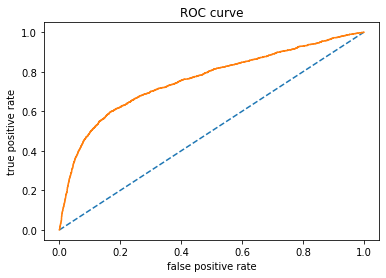

In [41]:
# 第二层LR
clf_second = LogisticRegression(solver = 'lbfgs')  
clf_second.fit(x_train_stack, trainy)
stacking_y_score = clf_second.predict_proba(x_test_stack)[:, 1]
roc_stacking = roc_auc_score(testy, stacking_y_score)
print('roc ',roc_stacking)
perfomance_clf(clf_second, x_test_stack, testy)
plot_roc(testy, stacking_y_score)


# 对多个分类器进行投票的方式

roc  0.7584933023034685


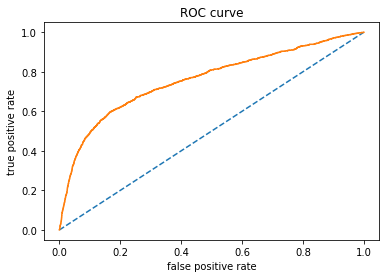

In [42]:
# vote
mean_y_score = x_test_stack.mean(axis = 1)
roc_vote = roc_auc_score(testy, mean_y_score)
print('roc ',roc_vote)    
plot_roc(testy, mean_y_score)

# 投票加上stacking

roc  0.7585175156148238


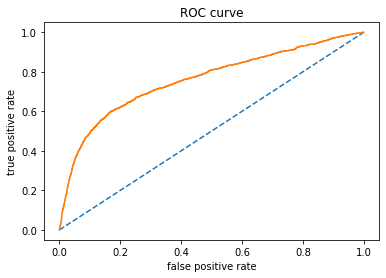

In [44]:
# vote + stack
x_test_stack_vote = np.hstack((x_test_stack, stacking_y_score.reshape(stacking_y_score.shape[0], 1)))
vote_stack_y_score = x_test_stack_vote.mean(axis = 1)
roc_vote = roc_auc_score(testy, vote_stack_y_score)
print('roc ',roc_vote)
plot_roc(testy, vote_stack_y_score)

In [49]:
clfs = [xgb.XGBClassifier(n_jobs = -1,
                          n_estimators = 100, 
                          max_depth = 3),
        AdaBoostClassifier(n_estimators = 200),
        GradientBoostingClassifier(n_estimators=110,
                                   min_samples_split=12,
                                   min_samples_leaf=6,
                                   max_depth=6),
                          ]

x_train_stack = np.zeros((trainx.shape[0], len(clfs)))
x_test_stack = np.zeros((testx.shape[0], len(clfs)))

n_folds = 10
skf = StratifiedKFold(n_splits = n_folds, shuffle = True, random_state = random_seed) # 2020
#############
# 第一层
for i, clf in enumerate(clfs):
    x_stack_test_n = np.zeros((testx.shape[0], n_folds))
    for j, (train_index, test_index) in enumerate(skf.split(trainx, trainy)):
        tr_x = trainx.iloc[train_index]
        tr_y = trainy.iloc[train_index]
        clf.fit(tr_x, tr_y)
        # 生成stacking训练数据集
        x_train_stack[test_index, i] = clf.predict_proba(trainx.iloc[test_index])[:, 1]
        x_stack_test_n[:, j] = clf.predict_proba(testx)[:, 1]
    # 生成stacking测试数据集
    x_test_stack[:, i] = x_stack_test_n.mean(axis = 1)


roc  0.7592021170720048
accuracy score is: 0.8184095178459612
precision score is: 0.6730538922155689
recall score is: 0.3231742380678551
auc: 0.7592021170720048
- - - - - - 


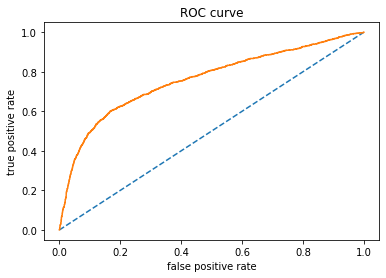

In [50]:
# 第二层LR
clf_second = LogisticRegression(solver = 'lbfgs')  
clf_second.fit(x_train_stack, trainy)
stacking_y_score = clf_second.predict_proba(x_test_stack)[:, 1]
roc_stacking = roc_auc_score(testy, stacking_y_score)
print('roc ',roc_stacking)
perfomance_clf(clf_second, x_test_stack, testy)
plot_roc(testy, stacking_y_score)


In [47]:
len(train_DF_weneed.columns.tolist())

62

In [48]:
train_DF_weneed.columns.tolist()

['flag',
 'gdr_cd',
 'age',
 'mrg_situ_cd',
 'acdm_deg_cd',
 'job_year',
 'fr_or_sh_ind',
 'dnl_mbl_bnk_ind',
 'dnl_bind_cmb_lif_ind',
 'hav_car_grp_ind',
 'frs_agn_dt_cnt',
 'cust_inv_rsk_endu_lvl_cd',
 'l6mon_daim_aum_cd',
 'tot_ast_lvl_cd',
 'pot_ast_lvl_cd',
 'l12mon_buy_fin_mng_whl_tms',
 'l12_mon_fnd_buy_whl_tms',
 'loan_act_ind',
 'pl_crd_lmt_cd',
 'ovd_30d_loan_tot_cnt',
 'his_lng_ovd_day',
 'hld_crd_card_grd_cd',
 'l1y_crd_card_csm_amt_dlm_cd',
 'perm_crd_lmt_cd',
 'cur_debit_cnt',
 'cur_credit_cnt',
 'cur_debit_min_opn_dt_cnt',
 'cur_credit_min_opn_dt_cnt',
 'cur_debit_crd_lvl',
 'I12_mon_whl_tms',
 'dnl_ind',
 'cur_debit_card',
 'cur_credit_card',
 'hav_car_hou_ind',
 'ovd_cnt',
 'ast_combine',
 'rsk_mean',
 'ast_mean',
 'most_Trx_Cod1_Cd',
 'most_Trx_Cod2_Cd',
 'cny_trx_income',
 'cny_trx_pay',
 'actual_income',
 'most_trx_way',
 'trx_tms',
 'Dat_Flg1_Cd_B',
 'Dat_Flg1_Cd_C',
 'Dat_Flg3_Cd_A',
 'Dat_Flg3_Cd_B',
 'Dat_Flg3_Cd_C',
 'beh_page_no_AAO',
 'beh_page_no_CQA',
 'beh